# Model Training: Defencemen - XGBRegressor

The task here will be to train a model to predict that value of NHL players who play the Defence position.

## Import our data

In [39]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [40]:
# Load in our data
filepath = '../../Data/Warehouse/MergedData/ML_data.csv' 
data = pd.read_csv(filepath)

In [41]:
defence = data[data['POSITION'].isin(['d, l', 'd'])].copy()

# Select only players with 41 or more games played
defence_41GP = defence[(defence['GP'] >= 41)].copy()
test_train_data = defence_41GP

# Get all numerical features from test_train_data that do not have NaN values
numerical_features = test_train_data.select_dtypes(include=['float64', 'int64']).columns[test_train_data.select_dtypes(include=['float64', 'int64']).isnull().sum() == 0]
numerical_features = numerical_features.drop(['GP', 'AAV', 'SALARY CAP PERCENTAGE', 'SALARY CAP'])

In [42]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features)
#     ]
# )

# pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=500, max_depth=6, reg_lambda=0, eta=0.01))]) # Grid Search optimal n_estimators=500, max_depth=5, reg_lambda=1, eta=0.01

# X = test_train_data[numerical_features]
# y = test_train_data['SALARY CAP PERCENTAGE']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)

# mse = mean_squared_error(y_test, y_pred)
# print(f'Mean Squared Error: {mse}')

In [43]:
X = test_train_data[numerical_features]
y = test_train_data['SALARY CAP PERCENTAGE']

# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the estimator for RFE
estimator = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=500, max_depth=6, reg_lambda=0, eta=0.01)

# Define the pipeline
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), numerical_features)])

# Use RFECV with cross validation for autmated feature selection
rfecv = RFECV(estimator=estimator, step=1, cv=KFold(5), scoring='neg_mean_squared_error', min_features_to_select=1)

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('selector', rfecv),
                           ('regressor', estimator)])

# Fitting the model
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'Optimal number of features : {rfecv.n_features_}')


Mean Squared Error: 0.0005237915819316516
Optimal number of features : 37


In [44]:
# Print the training performance score
print(f'Training performance score: {rfecv.score(X_train, y_train)}')

# Print the testing performance score
print(f'Testing performance score: {rfecv.score(X_test, y_test)}')

Training performance score: -1.6686577385274926
Testing performance score: -1.693932693882489


/Users/MichaelKuby/miniconda3/envs/dataScienceEnv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(
/Users/MichaelKuby/miniconda3/envs/dataScienceEnv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RFECV was fitted without feature names
  warnings.warn(


In [45]:
# Save the model to a file
import joblib

model_dir = 'Defence_Model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

joblib.dump(pipeline, f'{model_dir}/defence_salary_pipeline.pkl')
joblib.dump(numerical_features, f'{model_dir}/defence_salary_features.pkl')

['Defence_Model/defence_salary_features.pkl']

In [46]:
# # Perform Grid Search to find the optimal parameters
# param_grid = {
#     'regressor__n_estimators': [500, 1000, 1500],
#     'regressor__max_depth': [5, 10, 15],
#     'regressor__reg_lambda': [.1, 1, 10],
#     'regressor__eta': [0.01, 0.1, 0.3]
# }

# grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)
# print(grid_search.best_score_)
# print(grid_search.score(X_test, y_test))

# # {'regressor__eta': 0.01, 'regressor__max_depth': 5, 'regressor__n_estimators': 500, 'regressor__reg_lambda': 10}
# # 0.44245590658432327
# # 0.41148105470370877

In [47]:
def convert_to_dollars(df, col):
    return df[col].map('${:,.2f}'.format)

def invert_convert_to_dollars(df, col):
    return df[col].str.replace('$', '').str.replace(',', '').astype(float)


In [48]:
# Create a feature column in Centers for the predicted salary
defence['PRED_SALARY_PERCENTAGE'] = pipeline.predict(defence)

# Create a column for the actual predicted salary
defence['PRED_AAV'] = defence['PRED_SALARY_PERCENTAGE'] * defence['SALARY CAP']
defence['PRED_AAV'] = defence['PRED_AAV'].astype(int)

# Compute the differential between the predicted and actual salary
defence['DIFF'] = defence['PRED_AAV'] - defence['AAV']

# Convert to dollars
defence['PRED_AAV'] = convert_to_dollars(defence, 'PRED_AAV')
defence['AAV'] = convert_to_dollars(defence, 'AAV')
defence['DIFF'] = convert_to_dollars(defence, 'DIFF')

In [49]:
# Display the full record of the top 20 players based on 'PRED_SALARY_PERCENTAGE' 
top_20 = defence.sort_values('PRED_SALARY_PERCENTAGE', ascending=False).head(25)
display_features = ['PLAYER', 'SEASON']  + ['AAV', 'PRED_AAV', 'DIFF', 'PRED_SALARY_PERCENTAGE']
top_20[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
414,zdeno chara,2007-08,"$7,500,000.00","$6,885,387.00","$-614,613.00",0.136886
10023,erik karlsson,2021-22,"$11,500,000.00","$10,848,469.00","$-651,531.00",0.133110
11627,erik karlsson,2023-24,"$11,500,000.00","$10,442,581.00","$-1,057,419.00",0.125061
940,zdeno chara,2008-09,"$7,500,000.00","$6,860,439.00","$-639,561.00",0.120995
4875,p.k. subban,2014-15,"$9,000,000.00","$8,226,509.00","$-773,491.00",0.119225
8466,erik karlsson,2019-20,"$11,500,000.00","$9,715,841.00","$-1,784,159.00",0.119213
10861,erik karlsson,2022-23,"$11,500,000.00","$9,724,015.00","$-1,775,985.00",0.117867
1521,zdeno chara,2009-10,"$7,500,000.00","$6,663,963.00","$-836,037.00",0.117323
11606,drew doughty,2023-24,"$11,000,000.00","$9,794,684.00","$-1,205,316.00",0.117302
487,brian campbell,2008-09,"$7,142,875.00","$6,643,215.00","$-499,660.00",0.117164


In [50]:
# Display all seasons for Connor McDavid
cale_makar = defence[defence['PLAYER'] == 'cale makar']
cale_makar[display_features]

,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE
8349,cale makar,2019-20,"$2,854,166.00","$1,772,401.00","$-1,081,765.00",0.021747
9096,cale makar,2020-21,"$2,854,166.00","$1,650,536.00","$-1,203,630.00",0.020252
9899,cale makar,2021-22,"$9,000,000.00","$5,507,508.00","$-3,492,492.00",0.067577
11527,cale makar,2023-24,"$9,000,000.00","$6,590,279.00","$-2,409,721.00",0.078926


Text(0.5, 1.0, 'Distribution of Predicted Salary Percentage for Defence')

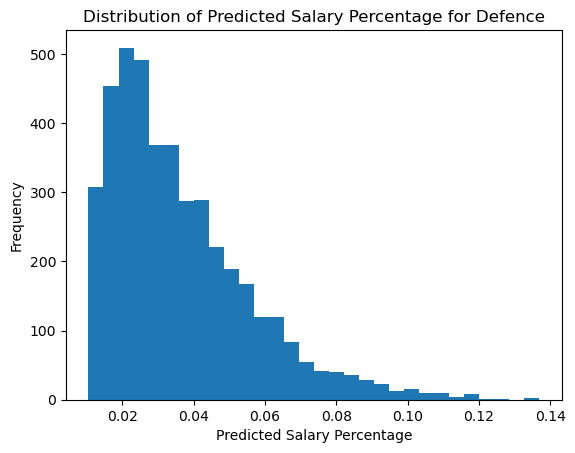

In [51]:
# Plot the distribution of PRED_SALARY_PERCENTAGE
plt.hist(defence['PRED_SALARY_PERCENTAGE'], bins=30)
plt.xlabel('Predicted Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Salary Percentage for Defence')

Text(0.5, 1.0, 'Distribution of Actual Salary Percentage for Defence')

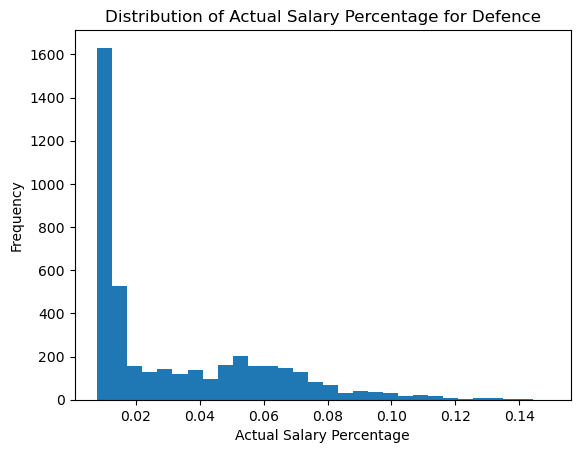

In [52]:
# Plot the distribution of Y_SALARY_CAP_PERCENTAGE
plt.hist(defence['SALARY CAP PERCENTAGE'], bins=30)
plt.xlabel('Actual Salary Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Actual Salary Percentage for Defence')

In [53]:
# Filter players with over 41 GP
filtered_data = defence[(defence['GP'] > 60) & (defence['SEASON'] == '2023-24')].copy()

# Convert AAV and PRED_SALARY_CAP_AAV back to float
filtered_data['AAV'] = invert_convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = invert_convert_to_dollars(filtered_data, 'PRED_AAV')

# Calculate differential between AAV and PRED_SALARY_CAP_AAV
filtered_data['Differential'] = filtered_data['PRED_AAV'] - filtered_data['AAV']

# Sort by differential in descending order
filtered_data = filtered_data.sort_values('Differential', ascending=False)

# Convert AAV and PRED_SALARY_CAP_AAV back to $
filtered_data['AAV'] = convert_to_dollars(filtered_data, 'AAV')
filtered_data['PRED_AAV'] = convert_to_dollars(filtered_data, 'PRED_AAV')

# Select top 5 players with largest differentials
top_players = filtered_data.head(10)

top_players[['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11695,ott,jake sanderson,2023-24,"$1,850,000.00","$5,021,257.00","$3,171,257.00",0.060135,3171257.0
11667,ari,j.j. moser,2023-24,"$925,000.00","$2,833,764.00","$1,908,764.00",0.033937,1908764.0
11585,t.b,darren raddysh,2023-24,"$762,500.00","$2,637,968.00","$1,875,468.00",0.031592,1875468.0
11521,min,brock faber,2023-24,"$1,008,333.00","$2,735,886.00","$1,727,553.00",0.032765,1727553.0
12074,dal,thomas harley,2023-24,"$1,288,333.00","$2,913,543.00","$1,625,210.00",0.034893,1625210.0
11706,dal,jani hakanpää,2023-24,"$1,500,000.00","$3,124,667.00","$1,624,667.00",0.037421,1624667.0
11952,fla,oliver ekman-larsson,2023-24,"$2,250,000.00","$3,821,014.00","$1,571,014.00",0.045761,1571014.0
11441,nyi,alexander romanov,2023-24,"$2,500,000.00","$4,037,096.00","$1,537,096.00",0.048348,1537096.0
11945,nyi,noah dobson,2023-24,"$4,000,000.00","$5,524,749.00","$1,524,749.00",0.066165,1524749.0
11534,phi,cam york,2023-24,"$1,600,000.00","$2,922,146.00","$1,322,146.00",0.034996,1322146.0


In [54]:
# Show all players who have a negative differential
filtered_data[filtered_data['Differential'] < 0][['TEAM'] + display_features + ['Differential']].tail(30)

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11704,sea,jamie oleksiak,2023-24,"$4,600,000.00","$3,962,547.00","$-637,453.00",0.047456,-637453.0
12015,nsh,ryan mcdonagh,2023-24,"$6,750,000.00","$5,992,044.00","$-757,956.00",0.071761,-757956.0
12084,phi,travis sanheim,2023-24,"$6,250,000.00","$5,491,862.00","$-758,138.00",0.065771,-758138.0
11564,stl,colton parayko,2023-24,"$6,500,000.00","$5,737,216.00","$-762,784.00",0.068709,-762784.0
12123,l.a,vladislav gavrikov,2023-24,"$5,875,000.00","$5,109,416.00","$-765,584.00",0.061191,-765584.0
12065,tor,tj brodie,2023-24,"$5,000,000.00","$4,221,737.00","$-778,263.00",0.050560,-778263.0
11745,n.j,john marino,2023-24,"$4,400,000.00","$3,613,446.00","$-786,554.00",0.043275,-786554.0
11923,wsh,nick jensen,2023-24,"$4,050,000.00","$3,217,571.00","$-832,429.00",0.038534,-832429.0
11623,cbj,erik gudbranson,2023-24,"$4,000,000.00","$3,138,645.00","$-861,355.00",0.037589,-861355.0
11513,edm,brett kulak,2023-24,"$2,750,000.00","$1,881,452.00","$-868,548.00",0.022532,-868548.0


In [55]:
# Show all players who have a positive differential
filtered_data[filtered_data['Differential'] > 0][['TEAM'] + display_features + ['Differential']].head(30)

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11695,ott,jake sanderson,2023-24,"$1,850,000.00","$5,021,257.00","$3,171,257.00",0.060135,3171257.0
11667,ari,j.j. moser,2023-24,"$925,000.00","$2,833,764.00","$1,908,764.00",0.033937,1908764.0
11585,t.b,darren raddysh,2023-24,"$762,500.00","$2,637,968.00","$1,875,468.00",0.031592,1875468.0
11521,min,brock faber,2023-24,"$1,008,333.00","$2,735,886.00","$1,727,553.00",0.032765,1727553.0
12074,dal,thomas harley,2023-24,"$1,288,333.00","$2,913,543.00","$1,625,210.00",0.034893,1625210.0
11706,dal,jani hakanpää,2023-24,"$1,500,000.00","$3,124,667.00","$1,624,667.00",0.037421,1624667.0
11952,fla,oliver ekman-larsson,2023-24,"$2,250,000.00","$3,821,014.00","$1,571,014.00",0.045761,1571014.0
11441,nyi,alexander romanov,2023-24,"$2,500,000.00","$4,037,096.00","$1,537,096.00",0.048348,1537096.0
11945,nyi,noah dobson,2023-24,"$4,000,000.00","$5,524,749.00","$1,524,749.00",0.066165,1524749.0
11534,phi,cam york,2023-24,"$1,600,000.00","$2,922,146.00","$1,322,146.00",0.034996,1322146.0


In [56]:
filtered_data[filtered_data['PLAYER'] == 'quinn hughes'][['TEAM'] + display_features + ['Differential']]

,TEAM,PLAYER,SEASON,AAV,PRED_AAV,DIFF,PRED_SALARY_PERCENTAGE,Differential
11983,van,quinn hughes,2023-24,"$7,850,000.00","$7,471,159.00","$-378,841.00",0.089475,-378841.0


In [57]:
predictions = defence[['PLAYER', 'SEASON', 'PRED_AAV','PRED_SALARY_PERCENTAGE']]

# Save predictions to disk
save_dir = '../../Data/Warehouse/Predictions/' 
filename = 'defence_predictions.csv'

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the predictions to disk
predictions.to_csv(save_dir + filename, index=True)